In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import halem.Base_functions as halem
import os
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from netCDF4 import Dataset, num2date
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import PercentFormatter


import matplotlib as mpl
import matplotlib.text as mtext
import matplotlib.font_manager as mfonts


def scale_bar_left(ax, bars=4, length=4, location=(0.1, 0.05), linewidth=3, col='black'):
    """
    ax is the axes to draw the scalebar on.
    bars is the number of subdivisions of the bar (black and white chunks)
    length is the length of the scalebar in km.
    location is left side of the scalebar in axis coordinates.
    (ie. 0 is the left side of the plot)
    linewidth is the thickness of the scalebar.
    color is the color of the scale bar
    """
    # Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    # Make tmc aligned to the left of the map,
    # vertically at scale bar location
    sbllx = llx0 + (llx1 - llx0) * location[0]
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    # Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    # Calculate a scale bar length if none has been given
    # (Theres probably a more pythonic way of rounding the number but this works)
    if not length:
        length = (x1 - x0) / 5000  # in km
        ndim = int(np.floor(np.log10(length)))  # number of digits in number
        length = round(length, -ndim)  # round to 1sf

        # Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']:
                return int(x)
            else:
                return scale_number(x - 10 ** ndim)

        length = scale_number(length)

    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx, sbx + length * 1000 / bars]
    # Plot the scalebar chunks
    barcol = 'white'
    for i in range(0, bars):
        # plot the chunk
        ax.plot(bar_xs, [sby, sby], transform=tmc, color=barcol, linewidth=linewidth)
        # alternate the colour
        if barcol == 'white':
            barcol = 'dimgrey'
        else:
            barcol = 'white'
        # Generate the x coordinate for the number
        bar_xt = sbx + i * length * 1000 / bars
        # Plot the scalebar label for that chunk
        ax.text(bar_xt, sby, str(round(i * length / bars)), transform=tmc,
                horizontalalignment='center', verticalalignment='bottom',
                color=col)
        # work out the position of the next chunk of the bar
        bar_xs[0] = bar_xs[1]
        bar_xs[1] = bar_xs[1] + length * 1000 / bars
    # Generate the x coordinate for the last number
    bar_xt = sbx + length * 1000
    # Plot the last scalebar label
    ax.text(bar_xt, sby, str(round(length)), transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color=col)
    # Plot the unit label below the bar
    bar_xt = sbx + length * 1000 / 2
    bar_yt = y0 + (y1 - y0) * (location[1] / 4)
    ax.text(bar_xt, bar_yt, 'km', transform=tmc, horizontalalignment='center',
            verticalalignment='bottom', color=col)

In [2]:
coords_WGS = np.loadtxt('E:/Use_case_Schouwen/baty_WGS.csv')   
start = [3.67670012, 51.70969009]                     # Location of the koppelpunt                             (lon, lat)
stop = [3.522637481591586,51.76880095558772]          # Location of the dredging area                          (lon, lat)

D_emp = 4.0
D_full = 8.0
ukc = 1.0
tide = -1.3

N = 100
x_r = np.arange(coords_WGS[:,0].min(), coords_WGS[:,0].max(), (coords_WGS[:,0].max() - coords_WGS[:,0].min())/N)
y_r = np.arange(coords_WGS[:,1].min(), coords_WGS[:,1].max(), (coords_WGS[:,1].max() - coords_WGS[:,1].min())/N)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = tide -  griddata(coords_WGS[:,:2], coords_WGS[:,2], (x_r, y_r), method= 'linear')
cval = [-1000,D_emp + ukc -3.3, D_emp +ukc, D_full+ukc, 100]
cval2 = [D_emp + ukc - 3.3, D_emp +ukc, D_full+ukc]

FM = np.loadtxt('05_DCSM-FM_100m/outputzuno.csv')
FMNB2 = np.loadtxt('06_DCSM-FM_100m_NB2/outputzuno.csv')
zuno = np.loadtxt('02_Zuno(Tidal-analysis)/outputzuno.csv')
base = np.loadtxt('01_Base_case_simple/outputzuno.csv')
zunonb3 = np.loadtxt('04_Zuno(Tidal-analysis)  NB  = 3/outputzuno.csv')
realz = np.loadtxt('09_Zuno_real_data/outputzuno.csv')
realznb3 = np.loadtxt('10_Zuno_real_data nb=2(second atempt)/outputzuno.csv')

FM2 = np.loadtxt('05_DCSM-FM_100m/outputzuno2.csv')
FMNB22 = np.loadtxt('06_DCSM-FM_100m_NB2/outputzuno2.csv')
zuno2 = np.loadtxt('02_Zuno(Tidal-analysis)/outputzuno2.csv')
base2 = np.loadtxt('01_Base_case_simple/outputzuno2.csv')
zunonb32 = np.loadtxt('04_Zuno(Tidal-analysis)  NB  = 3/outputzuno2.csv')
realz2 = np.loadtxt('09_Zuno_real_data/outputzuno2.csv')
realznb32 = np.loadtxt('10_Zuno_real_data nb=2(second atempt)/outputzuno2.csv')


histbase = np.loadtxt('01_Base_case_simple/hist')
histzuno = np.loadtxt('02_Zuno(Tidal-analysis)/hist')
histFM= np.loadtxt('05_DCSM-FM_100m/hist')
histFMNB2= np.loadtxt('06_DCSM-FM_100m_NB2/hist')
histzunonb3 = np.loadtxt('04_Zuno(Tidal-analysis)  NB  = 3/hist')
histrealz2 = np.loadtxt('09_Zuno_real_data/hist')
histrealznb32 = np.loadtxt('10_Zuno_real_data nb=2(second atempt)/hist')

nbase = np.loadtxt('01_Base_case_simple/n')
nzuno = np.loadtxt('02_Zuno(Tidal-analysis)/n')
nFM= np.loadtxt('05_DCSM-FM_100m/n')
nFMNB2= np.loadtxt('06_DCSM-FM_100m_NB2/n')
nzunonb3 = np.loadtxt('04_Zuno(Tidal-analysis)  NB  = 3/n')
nrealz2 = np.loadtxt('09_Zuno_real_data/n')
nrealznb32 = np.loadtxt('10_Zuno_real_data nb=2(second atempt)/n')

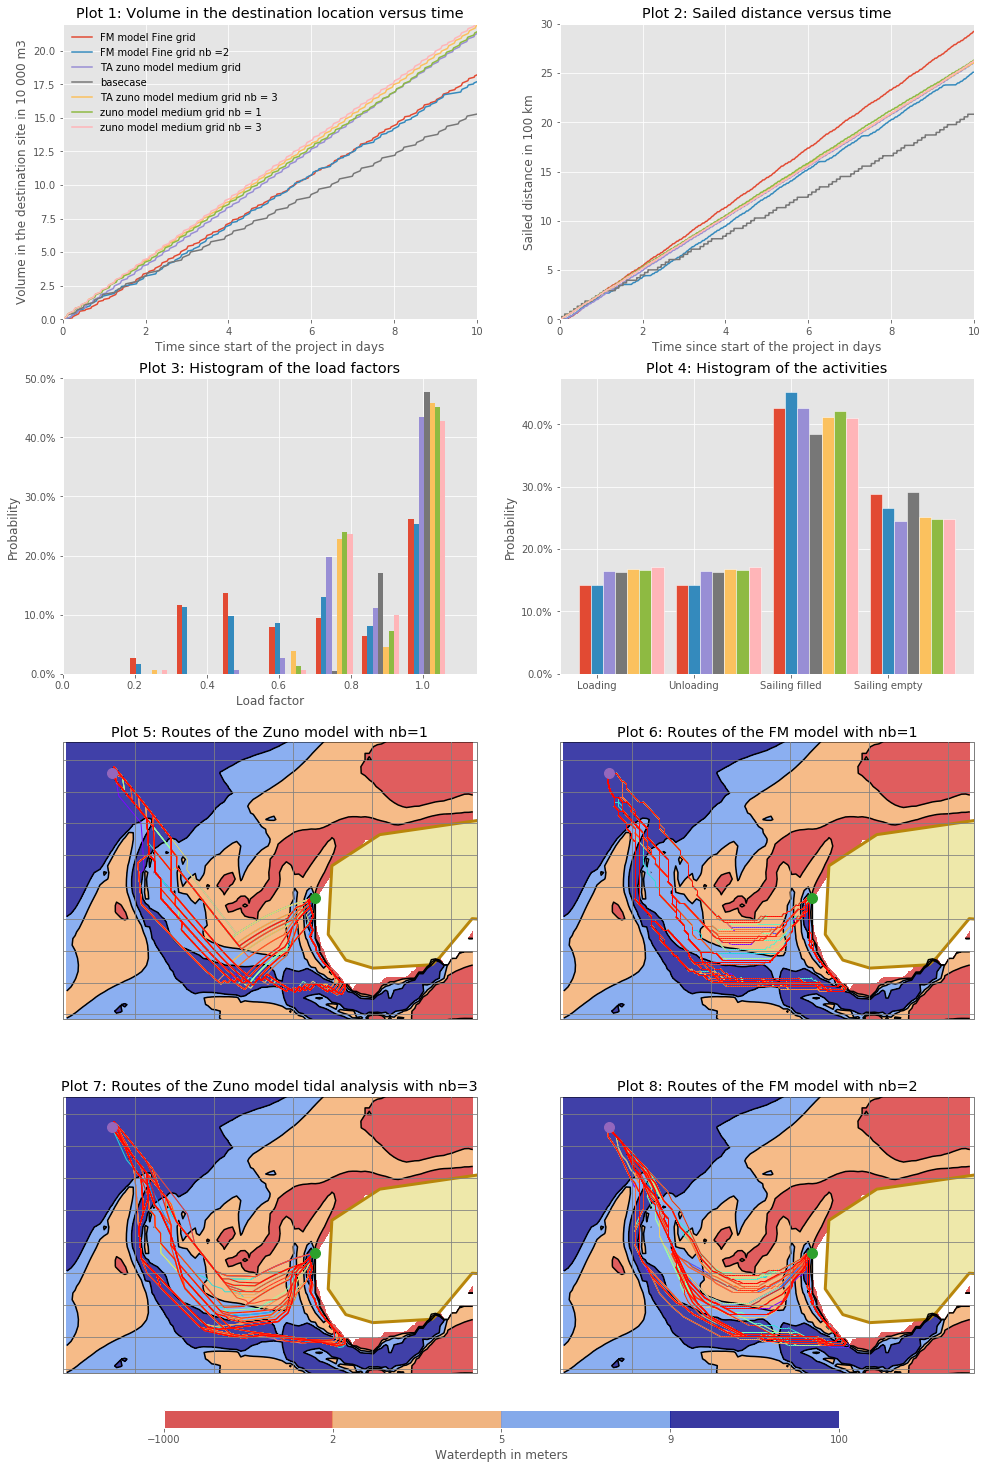

In [3]:
fig = plt.figure(figsize = (18.75,25))
plt.subplot(421)
plt.title('Plot 1: Volume in the destination location versus time')
plt.plot((FM[1] - FM[1][0])/24/3600, FM[0]/10000, label = 'FM model Fine grid')
plt.plot((FMNB2[1] - FMNB2[1][0])/24/3600, FMNB2[0]/10000, label = 'FM model Fine grid nb =2')
plt.plot((zuno[1] - zuno[1][0])/24/3600, zuno[0]/10000, label = 'TA zuno model medium grid')
plt.plot((base[1] - base[1][0])/24/3600, base[0]/10000, label = 'basecase')
plt.plot((zunonb3[1] - zunonb3[1][0])/24/3600, zunonb3[0]/10000, label = 'TA zuno model medium grid nb = 3')
plt.plot((realz[1] - realz[1][0])/24/3600, realz[0]/10000, label = 'zuno model medium grid nb = 1')
plt.plot((realznb3[1] - realznb3[1][0])/24/3600, realznb3[0]/10000, label = 'zuno model medium grid nb = 3')
plt.legend(loc = 'best', framealpha=0)
plt.xlim(0,10)
plt.ylim(0, 22)
plt.xlabel('Time since start of the project in days')
plt.ylabel('Volume in the destination site in 10 000 m3')

plt.subplot(422)
plt.title('Plot 2: Sailed distance versus time')
plt.plot((FM2[1] - FM2[1][0])/24/3600, FM2[0]/100000, label = 'FM model Fine grid')
plt.plot((FMNB22[1] - FMNB22[1][0])/24/3600, FMNB22[0]/100000, label = 'FM model Fine grid nb =2')
plt.plot((zuno2[1] - zuno2[1][0])/24/3600, zuno2[0]/100000, label = 'TA zuno model medium grid')
plt.plot((base2[1] - base2[1][0])/24/3600, base2[0]/100000, label = 'basecase')
plt.plot((zunonb32[1] - zunonb32[1][0])/24/3600, zunonb32[0]/100000, label = 'TA zuno model medium grid nb = 3')
plt.plot((realz2[1] - realz2[1][0])/24/3600, realz2[0]/100000, label = 'zuno model medium grid nb = 1')
plt.plot((realznb32[1] - realznb32[1][0])/24/3600, realznb32[0]/100000, label = 'zuno model medium grid nb = 1')
plt.xlim(0,10)
plt.ylim(0, 30)
plt.xlabel('Time since start of the project in days')
plt.ylabel('Sailed distance in 100 km')

plt.subplot(423)
n, bins, patches  = plt.hist([ histFM, histFMNB2, histzuno,histbase, histzunonb3, histrealz2, histrealznb32], 
                                 bins=30, 
                                 density=True, 
                                 label = ['FM model Fine grid nb =1', 
                                          'FM model Fine grid nb =2',
                                          'TA zuno model medium grid', 
                                          'basecase', 
                                          'TA zuno model medium grid nb = 3', 
                                          'zuno model medium grid nb = 1',
                                          'zuno model medium grid nb = 3'
                                         ]
                                ) 
plt.ylabel('Probability')
plt.xlabel('Load factor')
plt.title('Plot 3: Histogram of the load factors')
plt.xlim(0, 1.15)
plt.gca().yaxis.set_major_formatter(PercentFormatter(10))

plt.subplot(424)
plt.title('Plot 4: Histogram of the activities')
def f (bars1):
    B = 0
    for i in range(len(bars1)):
        bars_n = bars1[i] - B
        B = bars1[i]
        bars1[i] = bars_n
    return bars1

barWidth = 1/8
 
bars1 = f(nFM)
bars2 = f(nFMNB2)
bars3 = f(nzuno)
bars4 = f(nbase)
bars5 = f(nzunonb3)
bars6 = f(nrealz2)
bars7 = f(nrealznb32)
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]


plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='FM model Fine grid')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='FM model Fine grid NB = 2')
plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='Zuno model tidal analysis medium grid')
plt.bar(r4, bars4, width=barWidth, edgecolor='white', label='Basecase')
plt.bar(r5, bars5, width=barWidth, edgecolor='white', label='zuno model tidal analysis medium grid nb = 3')
plt.bar(r6, bars6, width=barWidth, edgecolor='white', label='Zuno model medium grid nb = 1')
plt.bar(r7, bars7, width=barWidth, edgecolor='white', label='Zuno model medium grid nb = 3')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xticks([r + barWidth for r in range(len(bars1))], ['Loading', 'Unloading', 'Sailing filled', 'Sailing empty'])
plt.ylabel('Probability')

ax = plt.subplot(425,projection=ccrs.Mercator())
im = plt.contourf(x_r,y_r,WD_r,cval,
                  transform=ccrs.PlateCarree(), 
                  colors = ('tab:red','sandybrown', 'cornflowerblue', 'darkblue'),
                  alpha = 0.75
                 )
plt.contour(x_r,y_r,WD_r,cval2,transform=ccrs.PlateCarree(), colors = 'black')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.coastlines(resolution='10m', color='darkgoldenrod', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.set_extent([coords_WGS[:,0].min(),coords_WGS[:,0].max(),coords_WGS[:,1].min()*1.0015,coords_WGS[:,1].max()*0.998])
plt.plot(start[0], start[1],'o',color = 'tab:green',transform=ccrs.PlateCarree(), label =  'Nourishment location', markersize = 10)
plt.plot(stop[0], stop[1], 'o',color = 'tab:purple',transform=ccrs.PlateCarree() , label = 'Mining location', markersize = 10)

segments = np.load('09_Zuno_real_data/segments.npy')
norma = np.arange(len(segments))
norm = plt.Normalize(0, len(segments))
lc = LineCollection(segments, linewidth = 1, cmap='rainbow', norm=norm, transform=ccrs.PlateCarree())
lc.set_array(norma)
line = ax.add_collection(lc)

plt.title(r'Plot 5: Routes of the Zuno model with nb=1')

ax = plt.subplot(426,projection=ccrs.Mercator())
im = plt.contourf(x_r,y_r,WD_r,cval,
                  transform=ccrs.PlateCarree(), 
                  colors = ('tab:red','sandybrown', 'cornflowerblue', 'darkblue'),
                  alpha = 0.75
                 )
plt.contour(x_r,y_r,WD_r,cval2,transform=ccrs.PlateCarree(), colors = 'black')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.coastlines(resolution='10m', color='darkgoldenrod', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.set_extent([coords_WGS[:,0].min(),coords_WGS[:,0].max(),coords_WGS[:,1].min()*1.0015,coords_WGS[:,1].max()*0.998])

plt.plot(start[0], start[1],'o',color = 'tab:green',transform=ccrs.PlateCarree(), label =  'Nourishment location', markersize = 10)
plt.plot(stop[0], stop[1], 'o',color = 'tab:purple',transform=ccrs.PlateCarree() , label = 'Mining location', markersize = 10)

segments = np.load('05_DCSM-FM_100m/segments.npy')
norma = np.arange(len(segments))
norm = plt.Normalize(0, len(segments))
lc = LineCollection(segments, linewidth = 1, cmap='rainbow', norm=norm, transform=ccrs.PlateCarree())
lc.set_array(norma)
line = ax.add_collection(lc)
plt.title(r'Plot 6: Routes of the FM model with nb=1')

ax = plt.subplot(427,projection=ccrs.Mercator())
im = plt.contourf(x_r,y_r,WD_r,cval,
                  transform=ccrs.PlateCarree(), 
                  colors = ('tab:red','sandybrown', 'cornflowerblue', 'darkblue'),
                  alpha = 0.75
                 )
plt.contour(x_r,y_r,WD_r,cval2,transform=ccrs.PlateCarree(), colors = 'black')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.coastlines(resolution='10m', color='darkgoldenrod', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.set_extent([coords_WGS[:,0].min(),coords_WGS[:,0].max(),coords_WGS[:,1].min()*1.0015,coords_WGS[:,1].max()*0.998])
plt.plot(start[0], start[1],'o',color = 'tab:green',transform=ccrs.PlateCarree(), label =  'Nourishment location', markersize = 10)
plt.plot(stop[0], stop[1], 'o',color = 'tab:purple',transform=ccrs.PlateCarree() , label = 'Mining location', markersize = 10)


segments = np.load('04_Zuno(Tidal-analysis)  NB  = 3/segments.npy')
norma = np.arange(len(segments))
norm = plt.Normalize(0, len(segments))
lc = LineCollection(segments, linewidth = 1, cmap='rainbow', norm=norm, transform=ccrs.PlateCarree())
lc.set_array(norma)
line = ax.add_collection(lc)

plt.title(r'Plot 7: Routes of the Zuno model tidal analysis with nb=3')

ax = plt.subplot(428,projection=ccrs.Mercator())
im = plt.contourf(x_r,y_r,WD_r,cval,
                  transform=ccrs.PlateCarree(), 
                  colors = ('tab:red','sandybrown', 'cornflowerblue', 'darkblue'),
                  alpha = 0.75
                 )
plt.contour(x_r,y_r,WD_r,cval2,transform=ccrs.PlateCarree(), colors = 'black')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.coastlines(resolution='10m', color='darkgoldenrod', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.set_extent([coords_WGS[:,0].min(),coords_WGS[:,0].max(),coords_WGS[:,1].min()*1.0015,coords_WGS[:,1].max()*0.998])
plt.plot(start[0], start[1],'o',color = 'tab:green',transform=ccrs.PlateCarree(), label =  'Nourishment location', markersize = 10)
plt.plot(stop[0], stop[1], 'o',color = 'tab:purple',transform=ccrs.PlateCarree() , label = 'Mining location', markersize = 10)

segments = np.load('06_DCSM-FM_100m_NB2/segments.npy')
norma = np.arange(len(segments))
norm = plt.Normalize(0, len(segments))
lc = LineCollection(segments, linewidth = 1, cmap='rainbow', norm=norm, transform=ccrs.PlateCarree())
lc.set_array(norma)
line = ax.add_collection(lc)

plt.title(r'Plot 8: Routes of the FM model with nb=2')



fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.2,0.1,0.5,0.01])
fig.colorbar(im, 
             cax=cbar_ax, 
             label = 'Waterdepth in meters',  
             orientation='horizontal',
            )


plt.savefig('results_usecase', dpi = 200)

plt.show()

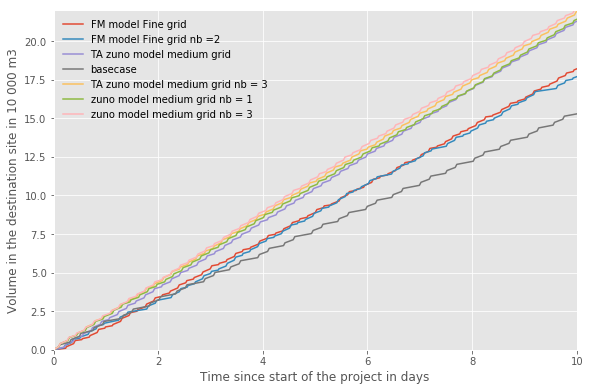

In [4]:
fig = plt.figure(figsize = (18.75/2,25/4))

plt.plot((FM[1] - FM[1][0])/24/3600, FM[0]/10000, label = 'FM model Fine grid')
plt.plot((FMNB2[1] - FMNB2[1][0])/24/3600, FMNB2[0]/10000, label = 'FM model Fine grid nb =2')
plt.plot((zuno[1] - zuno[1][0])/24/3600, zuno[0]/10000, label = 'TA zuno model medium grid')
plt.plot((base[1] - base[1][0])/24/3600, base[0]/10000, label = 'basecase')
plt.plot((zunonb3[1] - zunonb3[1][0])/24/3600, zunonb3[0]/10000, label = 'TA zuno model medium grid nb = 3')
plt.plot((realz[1] - realz[1][0])/24/3600, realz[0]/10000, label = 'zuno model medium grid nb = 1')
plt.plot((realznb3[1] - realznb3[1][0])/24/3600, realznb3[0]/10000, label = 'zuno model medium grid nb = 3')
plt.legend(loc = 'best', framealpha=0)
plt.xlim(0,10)
plt.ylim(0, 22)
plt.xlabel('Time since start of the project in days')
plt.ylabel('Volume in the destination site in 10 000 m3')

plt.savefig('Figure_5_a.svg')

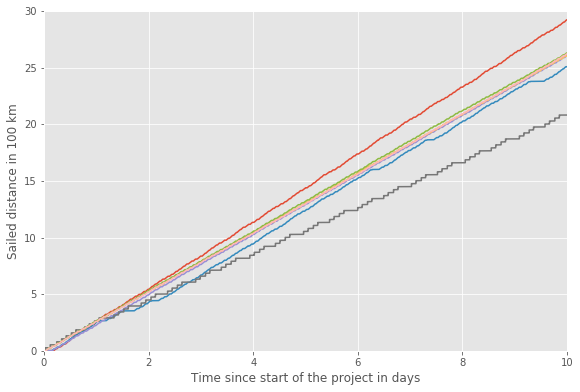

In [5]:
fig = plt.figure(figsize = (18.75/2,25/4))

plt.plot((FM2[1] - FM2[1][0])/24/3600, FM2[0]/100000, label = 'FM model Fine grid')
plt.plot((FMNB22[1] - FMNB22[1][0])/24/3600, FMNB22[0]/100000, label = 'FM model Fine grid nb =2')
plt.plot((zuno2[1] - zuno2[1][0])/24/3600, zuno2[0]/100000, label = 'TA zuno model medium grid')
plt.plot((base2[1] - base2[1][0])/24/3600, base2[0]/100000, label = 'basecase')
plt.plot((zunonb32[1] - zunonb32[1][0])/24/3600, zunonb32[0]/100000, label = 'TA zuno model medium grid nb = 3')
plt.plot((realz2[1] - realz2[1][0])/24/3600, realz2[0]/100000, label = 'zuno model medium grid nb = 1')
plt.plot((realznb32[1] - realznb32[1][0])/24/3600, realznb32[0]/100000, label = 'zuno model medium grid nb = 1')
plt.xlim(0,10)
plt.ylim(0, 30)
plt.xlabel('Time since start of the project in days')
plt.ylabel('Sailed distance in 100 km')

plt.savefig('Figure_5_b.svg')

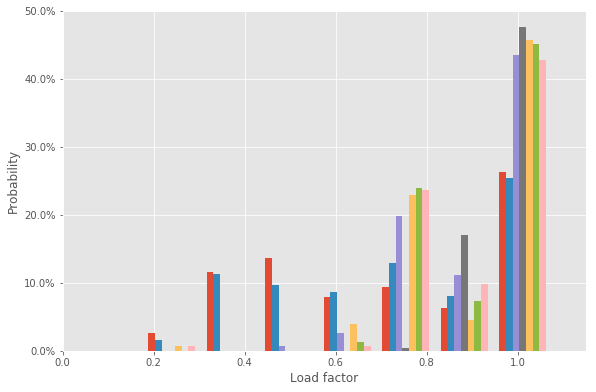

In [6]:
fig = plt.figure(figsize = (18.75/2,25/4))

n, bins, patches  = plt.hist([ histFM, histFMNB2, histzuno,histbase, histzunonb3, histrealz2, histrealznb32], 
                                 bins=30, 
                                 density=True, 
                                 label = ['FM model Fine grid nb =1', 
                                          'FM model Fine grid nb =2',
                                          'TA zuno model medium grid', 
                                          'basecase', 
                                          'TA zuno model medium grid nb = 3', 
                                          'zuno model medium grid nb = 1',
                                          'zuno model medium grid nb = 3'
                                         ]
                                ) 
plt.ylabel('Probability')
plt.xlabel('Load factor')
plt.xlim(0, 1.15)
plt.gca().yaxis.set_major_formatter(PercentFormatter(10))

plt.savefig('Figure_5_c.svg')

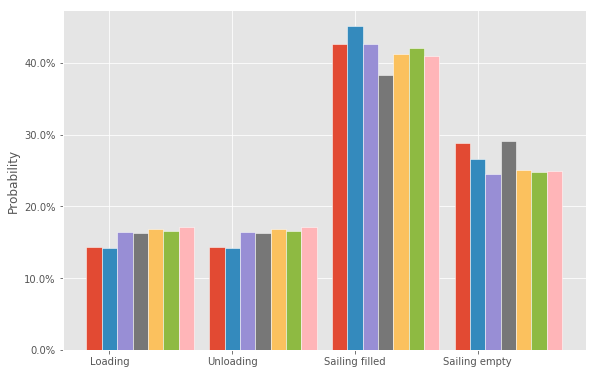

In [7]:
nbase = np.loadtxt('01_Base_case_simple/n')
nzuno = np.loadtxt('02_Zuno(Tidal-analysis)/n')
nFM= np.loadtxt('05_DCSM-FM_100m/n')
nFMNB2= np.loadtxt('06_DCSM-FM_100m_NB2/n')
nzunonb3 = np.loadtxt('04_Zuno(Tidal-analysis)  NB  = 3/n')
nrealz2 = np.loadtxt('09_Zuno_real_data/n')
nrealznb32 = np.loadtxt('10_Zuno_real_data nb=2(second atempt)/n')

fig = plt.figure(figsize = (18.75/2,25/4))

def f (bars1):
    B = 0
    for i in range(len(bars1)):
        bars_n = bars1[i] - B
        B = bars1[i]
        bars1[i] = bars_n
    return bars1

barWidth = 1/8
 
bars1 = f(nFM)
bars2 = f(nFMNB2)
bars3 = f(nzuno)
bars4 = f(nbase)
bars5 = f(nzunonb3)
bars6 = f(nrealz2)
bars7 = f(nrealznb32)
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]


plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='FM model Fine grid')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='FM model Fine grid NB = 2')
plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='Zuno model tidal analysis medium grid')
plt.bar(r4, bars4, width=barWidth, edgecolor='white', label='Basecase')
plt.bar(r5, bars5, width=barWidth, edgecolor='white', label='zuno model tidal analysis medium grid nb = 3')
plt.bar(r6, bars6, width=barWidth, edgecolor='white', label='Zuno model medium grid nb = 1')
plt.bar(r7, bars7, width=barWidth, edgecolor='white', label='Zuno model medium grid nb = 3')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xticks([r + barWidth for r in range(len(bars1))], ['Loading', 'Unloading', 'Sailing filled', 'Sailing empty'])
plt.ylabel('Probability')

plt.savefig('Figure_5_d.svg')

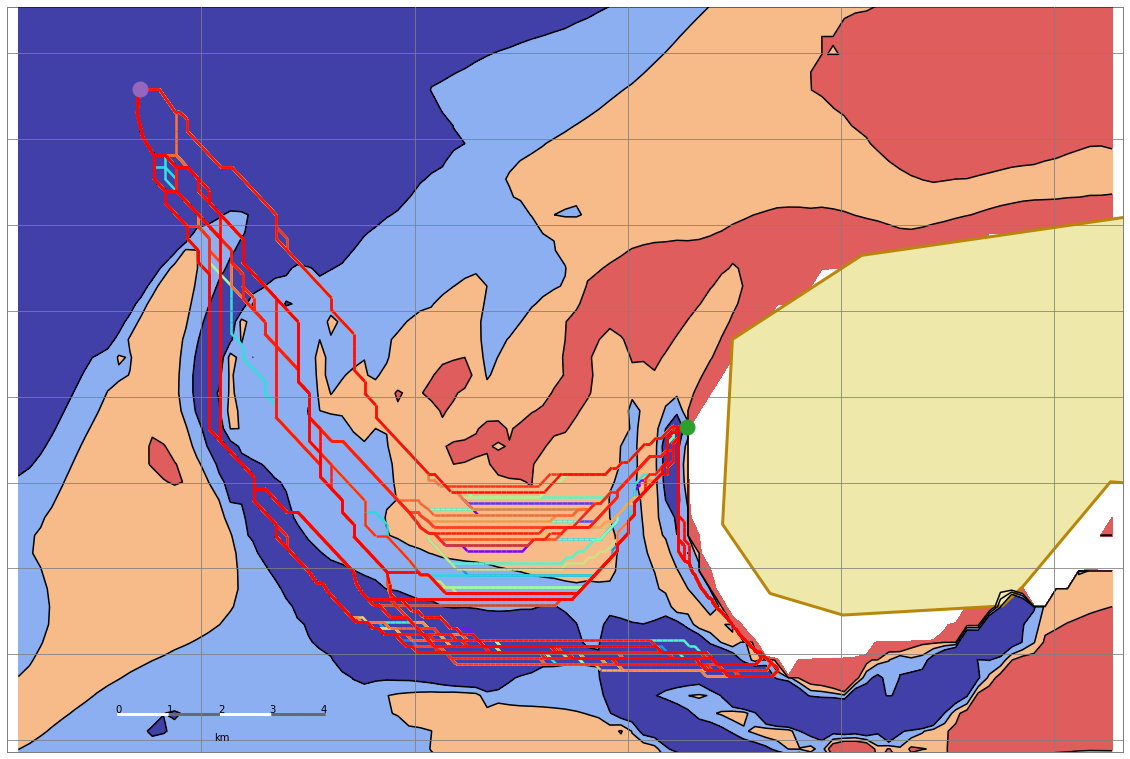

In [8]:
D_emp = 4.0
D_full = 8.0
ukc = 1.0
tide = -1.3

N = 100
x_r = np.arange(coords_WGS[:,0].min(), coords_WGS[:,0].max(), (coords_WGS[:,0].max() - coords_WGS[:,0].min())/N)
y_r = np.arange(coords_WGS[:,1].min(), coords_WGS[:,1].max(), (coords_WGS[:,1].max() - coords_WGS[:,1].min())/N)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = tide -  griddata(coords_WGS[:,:2], coords_WGS[:,2], (x_r, y_r), method= 'linear')
cval = [-1000,D_emp + ukc -3.3, D_emp +ukc, D_full+ukc, 100]
cval2 = [D_emp + ukc - 3.3, D_emp +ukc, D_full+ukc]

fig = plt.figure(figsize = (20,20))

ax = plt.subplot(projection=ccrs.Mercator())
im = plt.contourf(x_r,y_r,WD_r,cval,
                  transform=ccrs.PlateCarree(), 
                  colors = ('tab:red','sandybrown', 'cornflowerblue', 'darkblue'),
                  alpha = 0.75
                 )
plt.contour(x_r,y_r,WD_r,cval2,transform=ccrs.PlateCarree(), colors = 'black')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.coastlines(resolution='10m', color='darkgoldenrod', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.set_extent([coords_WGS[:,0].min(),coords_WGS[:,0].max(),coords_WGS[:,1].min()*1.0015,coords_WGS[:,1].max()*0.998])
plt.plot(start[0], start[1],'o',color = 'tab:green',transform=ccrs.PlateCarree(), label =  'Nourishment location', markersize = 15)
plt.plot(stop[0], stop[1], 'o',color = 'tab:purple',transform=ccrs.PlateCarree() , label = 'Mining location', markersize = 15)

segments = np.load('05_DCSM-FM_100m/segments.npy')
norma = np.arange(len(segments))
norm = plt.Normalize(0, len(segments))
lc = LineCollection(segments, linewidth = 2.5, cmap='rainbow', norm=norm, transform=ccrs.PlateCarree())
lc.set_array(norma)
line = ax.add_collection(lc)

scale_bar_left(ax)

plt.savefig('Figure_5_e.svg')

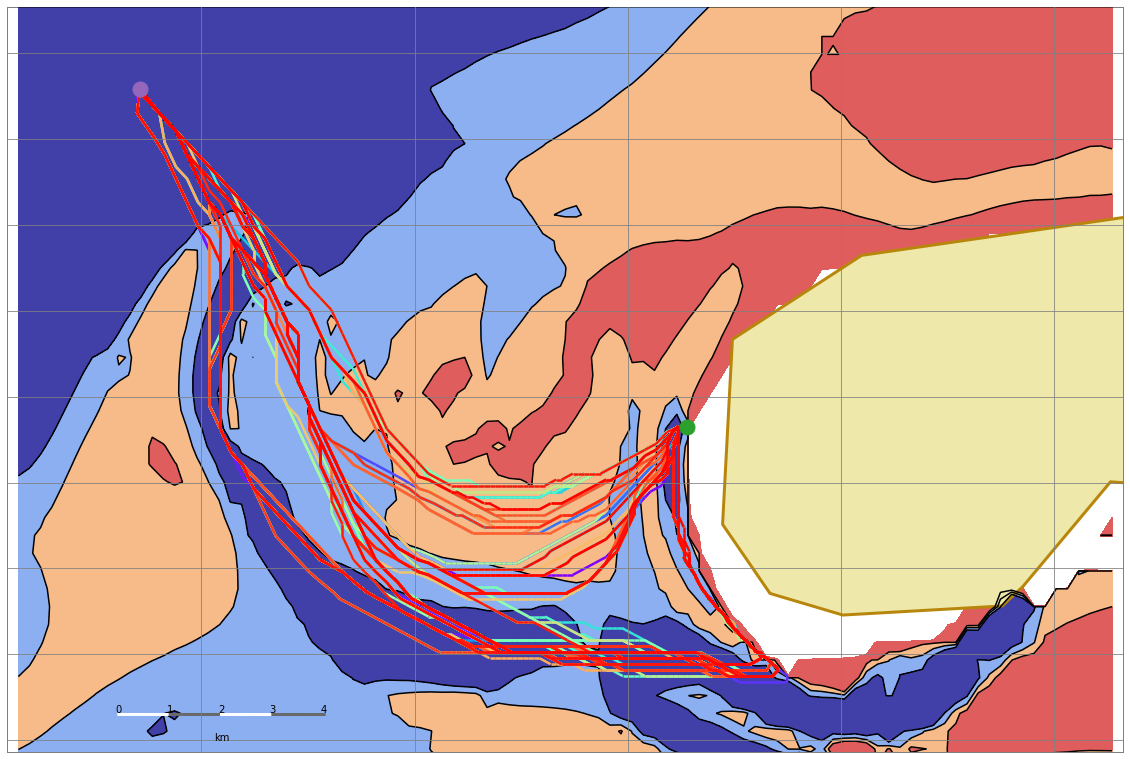

In [9]:
D_emp = 4.0
D_full = 8.0
ukc = 1.0
tide = -1.3

N = 100
x_r = np.arange(coords_WGS[:,0].min(), coords_WGS[:,0].max(), (coords_WGS[:,0].max() - coords_WGS[:,0].min())/N)
y_r = np.arange(coords_WGS[:,1].min(), coords_WGS[:,1].max(), (coords_WGS[:,1].max() - coords_WGS[:,1].min())/N)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = tide -  griddata(coords_WGS[:,:2], coords_WGS[:,2], (x_r, y_r), method= 'linear')
cval = [-1000,D_emp + ukc -3.3, D_emp +ukc, D_full+ukc, 100]
cval2 = [D_emp + ukc - 3.3, D_emp +ukc, D_full+ukc]

fig = plt.figure(figsize = (20,20))

ax = plt.subplot(projection=ccrs.Mercator())
im = plt.contourf(x_r,y_r,WD_r,cval,
                  transform=ccrs.PlateCarree(), 
                  colors = ('tab:red','sandybrown', 'cornflowerblue', 'darkblue'),
                  alpha = 0.75
                 )
plt.contour(x_r,y_r,WD_r,cval2,transform=ccrs.PlateCarree(), colors = 'black')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.coastlines(resolution='10m', color='darkgoldenrod', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.set_extent([coords_WGS[:,0].min(),coords_WGS[:,0].max(),coords_WGS[:,1].min()*1.0015,coords_WGS[:,1].max()*0.998])
plt.plot(start[0], start[1],'o',color = 'tab:green',transform=ccrs.PlateCarree(), label =  'Nourishment location', markersize = 15)
plt.plot(stop[0], stop[1], 'o',color = 'tab:purple',transform=ccrs.PlateCarree() , label = 'Mining location', markersize = 15)

segments = np.load('06_DCSM-FM_100m_NB2/segments.npy')
norma = np.arange(len(segments))
norm = plt.Normalize(0, len(segments))
lc = LineCollection(segments, linewidth = 2.5, cmap='rainbow', norm=norm, transform=ccrs.PlateCarree())
lc.set_array(norma)
line = ax.add_collection(lc)

scale_bar_left(ax)

plt.savefig('Figure_5_f.svg')

In [ ]:
nrealz2 = np.loadtxt('09_Zuno_real_data/n')
nrealznb32 = np.loadtxt('10_Zuno_real_data nb=2(second atempt)/n')

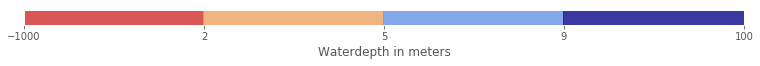

In [10]:
fig2 = plt.figure(figsize = (20,20))

fig.subplots_adjust(right=0.8)
cbar_ax = fig2.add_axes([0.2,0.1,0.5,0.01])
fig.colorbar(im, 
             cax=cbar_ax, 
             label = 'Waterdepth in meters',  
             orientation='horizontal',
            )

plt.savefig('Figure_5_g.svg')

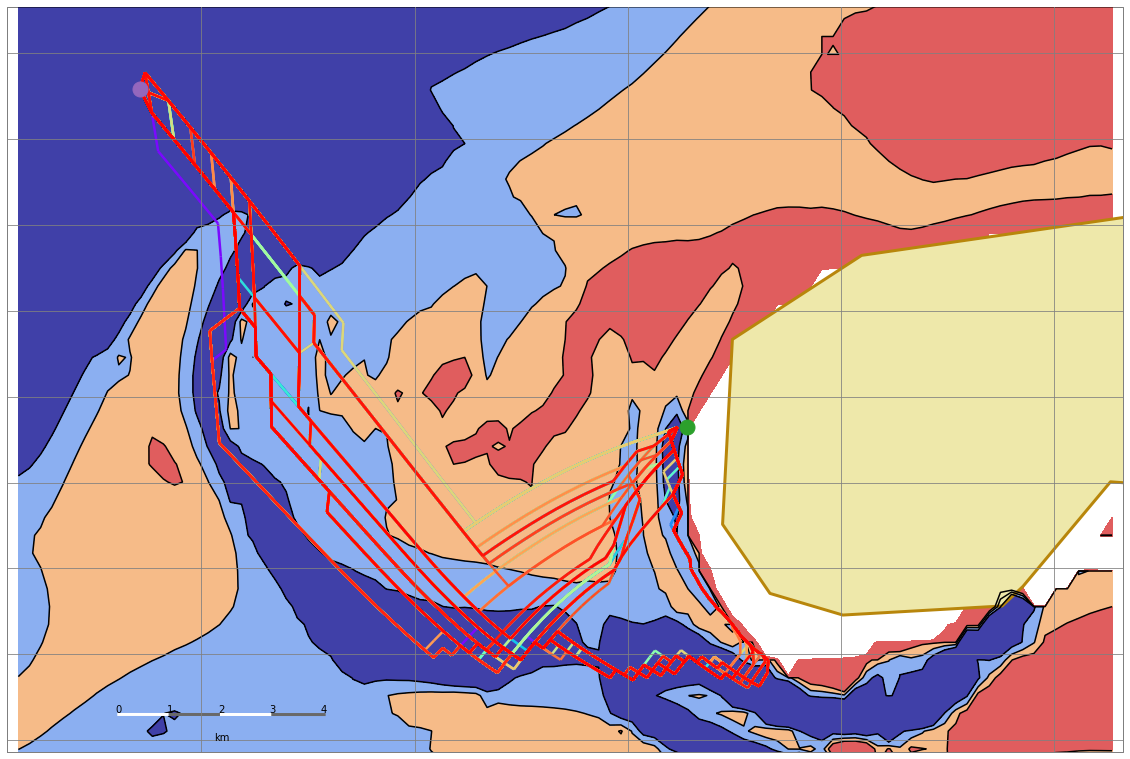

In [11]:
D_emp = 4.0
D_full = 8.0
ukc = 1.0
tide = -1.3

N = 100
x_r = np.arange(coords_WGS[:,0].min(), coords_WGS[:,0].max(), (coords_WGS[:,0].max() - coords_WGS[:,0].min())/N)
y_r = np.arange(coords_WGS[:,1].min(), coords_WGS[:,1].max(), (coords_WGS[:,1].max() - coords_WGS[:,1].min())/N)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = tide -  griddata(coords_WGS[:,:2], coords_WGS[:,2], (x_r, y_r), method= 'linear')
cval = [-1000,D_emp + ukc -3.3, D_emp +ukc, D_full+ukc, 100]
cval2 = [D_emp + ukc - 3.3, D_emp +ukc, D_full+ukc]

fig = plt.figure(figsize = (20,20))

ax = plt.subplot(projection=ccrs.Mercator())
im = plt.contourf(x_r,y_r,WD_r,cval,
                  transform=ccrs.PlateCarree(), 
                  colors = ('tab:red','sandybrown', 'cornflowerblue', 'darkblue'),
                  alpha = 0.75
                 )
plt.contour(x_r,y_r,WD_r,cval2,transform=ccrs.PlateCarree(), colors = 'black')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.coastlines(resolution='10m', color='darkgoldenrod', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.set_extent([coords_WGS[:,0].min(),coords_WGS[:,0].max(),coords_WGS[:,1].min()*1.0015,coords_WGS[:,1].max()*0.998])
plt.plot(start[0], start[1],'o',color = 'tab:green',transform=ccrs.PlateCarree(), label =  'Nourishment location', markersize = 15)
plt.plot(stop[0], stop[1], 'o',color = 'tab:purple',transform=ccrs.PlateCarree() , label = 'Mining location', markersize = 15)

segments = np.load('09_Zuno_real_data/segments.npy')
norma = np.arange(len(segments))
norm = plt.Normalize(0, len(segments))
lc = LineCollection(segments, linewidth = 2.5, cmap='rainbow', norm=norm, transform=ccrs.PlateCarree())
lc.set_array(norma)
line = ax.add_collection(lc)

scale_bar_left(ax)

# plt.savefig('Figure_5_f.svg')

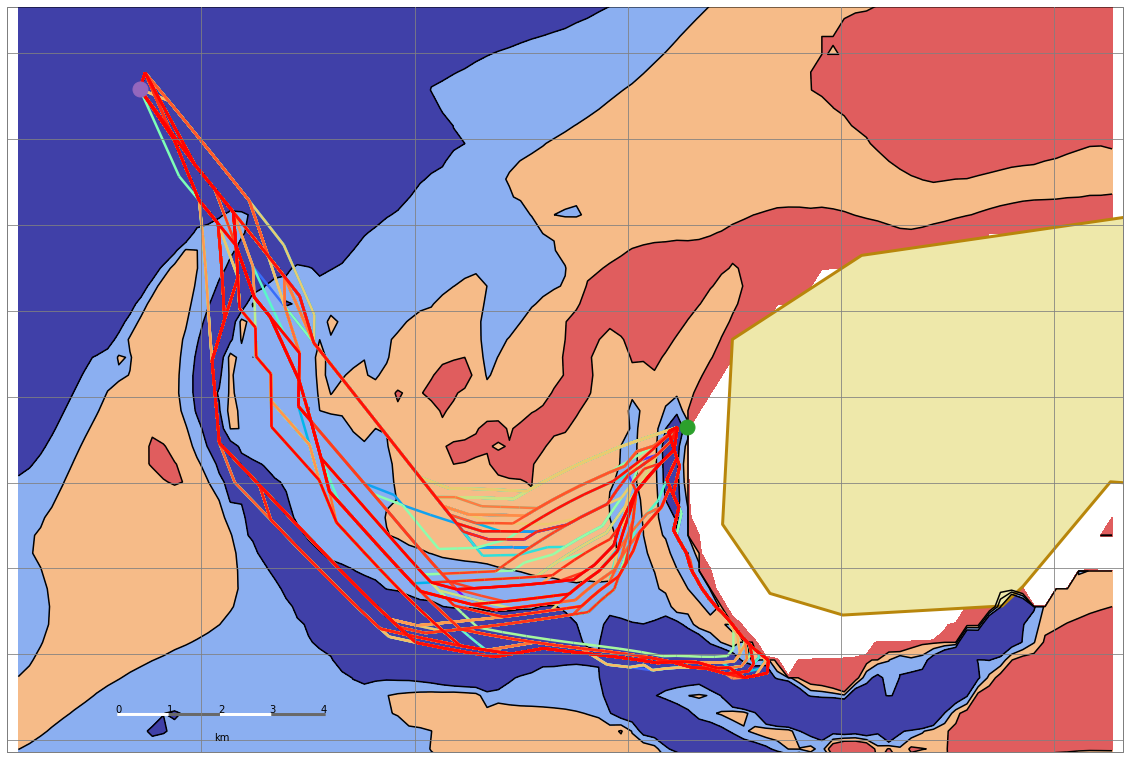

In [12]:
D_emp = 4.0
D_full = 8.0
ukc = 1.0
tide = -1.3

N = 100
x_r = np.arange(coords_WGS[:,0].min(), coords_WGS[:,0].max(), (coords_WGS[:,0].max() - coords_WGS[:,0].min())/N)
y_r = np.arange(coords_WGS[:,1].min(), coords_WGS[:,1].max(), (coords_WGS[:,1].max() - coords_WGS[:,1].min())/N)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = tide -  griddata(coords_WGS[:,:2], coords_WGS[:,2], (x_r, y_r), method= 'linear')
cval = [-1000,D_emp + ukc -3.3, D_emp +ukc, D_full+ukc, 100]
cval2 = [D_emp + ukc - 3.3, D_emp +ukc, D_full+ukc]

fig = plt.figure(figsize = (20,20))

ax = plt.subplot(projection=ccrs.Mercator())
im = plt.contourf(x_r,y_r,WD_r,cval,
                  transform=ccrs.PlateCarree(), 
                  colors = ('tab:red','sandybrown', 'cornflowerblue', 'darkblue'),
                  alpha = 0.75
                 )
plt.contour(x_r,y_r,WD_r,cval2,transform=ccrs.PlateCarree(), colors = 'black')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.coastlines(resolution='10m', color='darkgoldenrod', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.set_extent([coords_WGS[:,0].min(),coords_WGS[:,0].max(),coords_WGS[:,1].min()*1.0015,coords_WGS[:,1].max()*0.998])
plt.plot(start[0], start[1],'o',color = 'tab:green',transform=ccrs.PlateCarree(), label =  'Nourishment location', markersize = 15)
plt.plot(stop[0], stop[1], 'o',color = 'tab:purple',transform=ccrs.PlateCarree() , label = 'Mining location', markersize = 15)

segments = np.load('10_Zuno_real_data nb=2(second atempt)/segments.npy')
norma = np.arange(len(segments))
norm = plt.Normalize(0, len(segments))
lc = LineCollection(segments, linewidth = 2.5, cmap='rainbow', norm=norm, transform=ccrs.PlateCarree())
lc.set_array(norma)
line = ax.add_collection(lc)

scale_bar_left(ax)

# plt.savefig('Figure_5_f.svg')